## Import

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import random
import joblib
import json
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold, learning_curve
from matplotlib import pyplot as plt

# Models
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor, RandomForestRegressor

from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Evaluation
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error

## Constants

In [2]:
LOAD_DATA = True # Toggle if train-test data is not created yet

DATA_DIR = "data/"
DATA_FILE = "clean_data.csv"
INPUT_PATH  = os.path.join(DATA_DIR, DATA_FILE)

OUTPUT_DIR = "outputs/"
MODEL_DIR = os.path.join(OUTPUT_DIR, "models/")
DATA_SPLITS = os.path.join(OUTPUT_DIR, "splits/")

if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)
    os.mkdir(MODEL_DIR)
    os.mkdir(DATA_SPLITS)

GLOBAL_SEED = 63

In [3]:
def set_global_seed():
    random.seed(GLOBAL_SEED)
    np.random.seed(GLOBAL_SEED)

set_global_seed()

## Data Processing

In [4]:
df = pd.read_csv(INPUT_PATH)
X=df.drop(['Combined Load'],axis=1)
Y = df[['Combined Load']]

In [5]:
if LOAD_DATA:
    X_train = pd.read_csv(os.path.join(DATA_SPLITS,'X_train.csv'))
    X_test = pd.read_csv(os.path.join(DATA_SPLITS, 'X_test.csv'))
    y_train = pd.read_csv(os.path.join(DATA_SPLITS, 'y_train.csv'))
    y_test = pd.read_csv(os.path.join(DATA_SPLITS, 'y_test.csv'))
else:
    X_train, X_test, y_train, y_test, = train_test_split(
        X, 
        Y,
        test_size=0.10, 
        random_state = GLOBAL_SEED
    )

    X_train.to_csv(os.path.join(DATA_SPLITS,'X_train.csv'), index=False)
    X_test.to_csv(os.path.join(DATA_SPLITS, 'X_test.csv'), index=False)
    y_train.to_csv(os.path.join(DATA_SPLITS, 'y_train.csv'), index=False)
    y_test.to_csv(os.path.join(DATA_SPLITS, 'y_test.csv'), index=False)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((691, 8), (77, 8), (691, 1), (77, 1))

## Modeling

A few models will be tested and tuned, then the best performing model will be saved for later uses.

In [6]:
cv = RepeatedKFold(
    n_splits=5,
    n_repeats=10,
    random_state=GLOBAL_SEED
)

In [7]:
def tune_model(estimator, param_grid, model_name):
    grid_search_model = GridSearchCV(
        estimator,
        param_grid,
        verbose=1,
        cv=cv, 
        return_train_score=True,
        scoring='r2',
        n_jobs=-1
    )

    print(f"Tuning {model_name}")
    grid_search_model.fit(X_train, y_train)

    print(f"R-Squared::{grid_search_model.best_score_}")
    print(f"Best Hyperparameters:\n{grid_search_model.best_params_}")

    joblib.dump(grid_search_model, os.path.join(MODEL_DIR, f'{model_name.lower().replace(" ", "_")}.joblib'))

    return grid_search_model

1. Decision Tree Regressor

In [10]:
decision_tree_hyperparameters = {
    "max_depth": [5, 7, 10, 20, 30],
    "min_samples_split": [2, 5, 10, 15, 20],
    "min_samples_leaf": [1, 2, 4, 7],
    "max_features": ["sqrt", "log2", None],
    "criterion": ["squared_error", "absolute_error"]
}

decision_tree = DecisionTreeRegressor()
grid_search_decision_tree = tune_model(decision_tree, decision_tree_hyperparameters, "Decision Tree")

Tuning Decision Tree
Fitting 50 folds for each of 600 candidates, totalling 30000 fits
R-Squared::0.9908998673413849
Best Hyperparameters:
{'criterion': 'squared_error', 'max_depth': 7, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5}


2. GradientBoostingRegressor

In [11]:
gbr_hyperparameters = {
    "n_estimators": [100, 200, 500],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 5, 8],
    "subsample": [0.8, 0.9, 1.0]
}

gbr = GradientBoostingRegressor()
grid_search_gbr = tune_model(gbr, gbr_hyperparameters, "Gradient Boosting Regressor")

Tuning Gradient Boosting Regressor
Fitting 50 folds for each of 81 candidates, totalling 4050 fits
R-Squared::0.9981324320376619
Best Hyperparameters:
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500, 'subsample': 0.9}


3. AdaBoostRegressor

In [12]:
abr_hyperparameters = {
    "n_estimators": [100, 200, 500],
    "learning_rate": [0.01, 0.05, 0.1, 1.0],
    "loss": ['linear', 'square', 'exponential']
}

abr = AdaBoostRegressor()
grid_search_abr = tune_model(abr, abr_hyperparameters, "AdaBoost Regressor")

Tuning AdaBoost Regressor
Fitting 50 folds for each of 36 candidates, totalling 1800 fits
R-Squared::0.9752855457613766
Best Hyperparameters:
{'learning_rate': 1.0, 'loss': 'square', 'n_estimators': 500}


4. BaggingRegressor

In [13]:
br_hyperparameters = {
    "n_estimators": [10, 50, 100],
    "max_samples": [0.5, 0.8, 1.0],
    "max_features": [0.5, 0.8, 1.0]
}

br = BaggingRegressor()
grid_search_br = tune_model(br, br_hyperparameters, "Bagging Regressor")

Tuning Bagging Regressor
Fitting 50 folds for each of 27 candidates, totalling 1350 fits
R-Squared::0.9918189227820582
Best Hyperparameters:
{'max_features': 1.0, 'max_samples': 0.8, 'n_estimators': 100}


5. RandomForestRegressor

In [14]:
rfr_hyperparameters = {
    "n_estimators": [100, 200, 500],
    "max_features": ['sqrt', 'log2', 1.0],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "bootstrap": [True, False]
}

rfr = RandomForestRegressor()
grid_search_rfr = tune_model(rfr, rfr_hyperparameters, "Random Forest Regressor")

Tuning Random Forest Regressor
Fitting 50 folds for each of 216 candidates, totalling 10800 fits
R-Squared::0.9926090316573876
Best Hyperparameters:
{'bootstrap': True, 'max_depth': None, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 500}


6. XGBRegressor

In [15]:
xgbr_hyperparameters = {
    "n_estimators": [100, 500, 600],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 5, 7],
    "min_child_weight": [1, 3, 5],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0]
}

xgbr = XGBRegressor()
grid_search_xgbr = tune_model(xgbr, xgbr_hyperparameters, "XGBoost Regressor")

Tuning XGBoost Regressor
Fitting 50 folds for each of 729 candidates, totalling 36450 fits
R-Squared::0.9981028854846954
Best Hyperparameters:
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 600, 'subsample': 0.8}


7. LGBMRegressor

In [16]:
lgbmr_hyperparameters = {
    "num_leaves": [20, 31, 50, 70],
    "min_child_samples": [20, 50, 100],
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [100, 500, 1000],
    "max_depth": [-1, 5, 10]
}

lgbmr = LGBMRegressor(verbosity=-1)
grid_search_lgbmr = tune_model(lgbmr, lgbmr_hyperparameters, "LGBM Regressor")

Tuning LGBM Regressor
Fitting 50 folds for each of 324 candidates, totalling 16200 fits
R-Squared::0.9973004148158187
Best Hyperparameters:
{'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'n_estimators': 1000, 'num_leaves': 31}


8. CatBoostRegressor

In [17]:
cbr_hyperparameters = {
    "n_estimators": [500, 700, 1000],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "depth": [4, 6, 8],
    "l2_leaf_reg": [1, 3, 5, 7],
    "border_count": [32, 64, 128, 254]
}

cbr = CatBoostRegressor(logging_level='Silent')
grid_search_cbr = tune_model(cbr, cbr_hyperparameters, "Catboost Regressor")

Tuning Catboost Regressor
Fitting 50 folds for each of 576 candidates, totalling 28800 fits
R-Squared::0.9983371691529735
Best Hyperparameters:
{'border_count': 32, 'depth': 6, 'l2_leaf_reg': 1, 'learning_rate': 0.1, 'n_estimators': 1000}


## Evaluation on Test Data

In [18]:
best_models = {}

best_models['AdaBoost Regressor'] = joblib.load(os.path.join(MODEL_DIR, 'adaBoost_regressor.joblib'))
best_models['Bagging Regressor'] = joblib.load(os.path.join(MODEL_DIR, 'bagging_regressor.joblib'))
best_models['Catboost Regressor'] = joblib.load(os.path.join(MODEL_DIR, 'catboost_regressor.joblib'))
best_models['Decision Tree'] = joblib.load(os.path.join(MODEL_DIR, 'decision_tree.joblib'))
best_models['Gradient Boosting Regressor'] = joblib.load(os.path.join(MODEL_DIR, 'gradient_boosting_regressor.joblib'))
best_models['LGBM Regressor'] = joblib.load(os.path.join(MODEL_DIR, 'lgbm_regressor.joblib'))
best_models['Xgboost Regressor'] = joblib.load(os.path.join(MODEL_DIR, 'xgboost_regressor.joblib'))
best_models['Random Forest Regressor'] = joblib.load(os.path.join(MODEL_DIR, 'random_forest_regressor.joblib'))

test_results = {}

In [19]:
for name, estimator in best_models.items():
    y_pred = estimator.predict(X_test)
    print(f"Evaluating {name}")

    test_results[name] = {}
    
    r2 = r2_score(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    print(f"\tR2 Score: {r2}")
    print(f"\tRMSE Score: {rmse}")
    print(f"\tMAE Score: {mae}\n")

    test_results[name] = {
        "R2": r2,
        "RMSE": rmse,
        "MAE": mae
    }

Evaluating AdaBoost Regressor
	R2 Score: 0.973176005029092
	RMSE Score: 3.0093667963415496
	MAE Score: 2.431925494470635

Evaluating Bagging Regressor
	R2 Score: 0.9929470360586591
	RMSE Score: 1.5431183195985068
	MAE Score: 1.0365096103896103

Evaluating Catboost Regressor
	R2 Score: 0.9990235209776821
	RMSE Score: 0.5741757604941654
	MAE Score: 0.37071633633105083

Evaluating Decision Tree
	R2 Score: 0.989313498469852
	RMSE Score: 1.8994644576312443
	MAE Score: 1.2283833428168445

Evaluating Gradient Boosting Regressor
	R2 Score: 0.9985977023980565
	RMSE Score: 0.688071375450519
	MAE Score: 0.43543080048365096

Evaluating LGBM Regressor
	R2 Score: 0.997914784916237
	RMSE Score: 0.8390518983253548
	MAE Score: 0.578757564488566

Evaluating Xgboost Regressor
	R2 Score: 0.9984466433525085
	RMSE Score: 0.7241888322593002
	MAE Score: 0.47577428347104533

Evaluating Random Forest Regressor
	R2 Score: 0.9935928373460902
	RMSE Score: 1.4707751044243111
	MAE Score: 1.0452858787878887



In [20]:
with open(os.path.join(OUTPUT_DIR, 'test_results.json'), 'w') as f:
    json.dump(test_results, f, indent=4)

### Plotting the results

In [21]:
def plot_sorted_metric(ax, values_dict, title, xlabel):
    sorted_items = sorted(values_dict.items(), key=lambda x: x[1])
    models = [k for k, _ in sorted_items]
    values = [v for _, v in sorted_items]

    ax.barh(models, values)
    ax.set_title(title)
    ax.set_xlabel(xlabel)

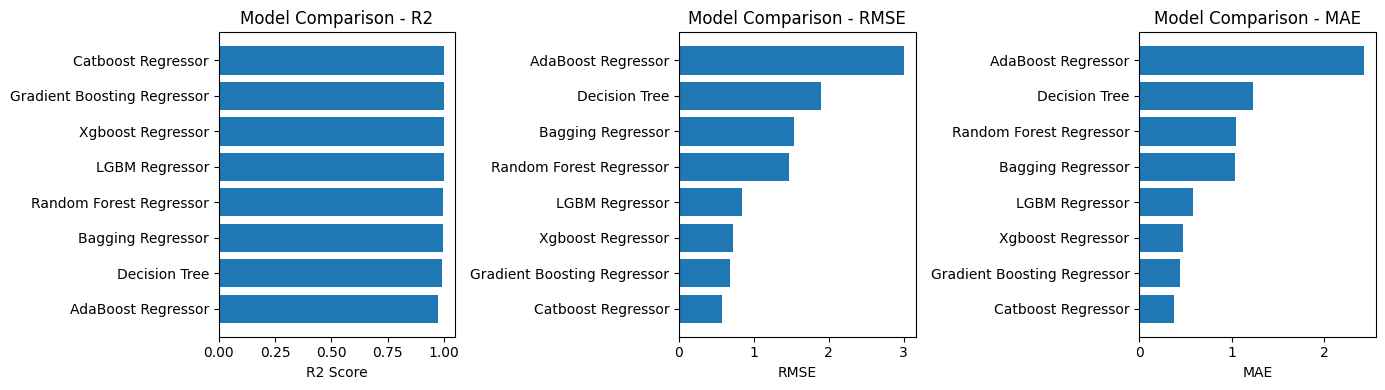

In [32]:
metrics = ["R2", "RMSE", "MAE"]
fig, axes = plt.subplots(
    nrows=1,
    ncols=3,
    figsize=(14, 4),
    gridspec_kw={"height_ratios": [1]}
)

# Plot R2, RMSE and MAE for combined load
for col, metric in enumerate(metrics):
    values = {
        model: test_results[model][metric]
        for model in test_results
    }
    xlabel = metric if metric != "R2" else "R2 Score"
    plot_sorted_metric(axes[col], values, f'Model Comparison - {metric}', xlabel)


plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'model_comparison.png'))
plt.show()

Based on all the test metrics, Catboost seems to be the best model. So, this will be used for the next tasks.

In [ ]:
best_params = best_models['Catboost Regressor'].best_params_
best_params

{'border_count': 32,
 'depth': 6,
 'l2_leaf_reg': 1,
 'learning_rate': 0.1,
 'n_estimators': 1000}

In [ ]:
# Uncomment to skip parameter tuning again

# model_study = joblib.load(os.path.join(MODEL_DIR, "catboost_regressor.joblib"))
# best_params = model_study.best_params_
# best_params

{'border_count': 32,
 'depth': 6,
 'l2_leaf_reg': 1,
 'learning_rate': 0.1,
 'n_estimators': 1000}

In [9]:
best_model = CatBoostRegressor(**best_params, logging_level='Silent')

In [10]:
train_sizes, train_scores, val_scores = learning_curve(
    best_model, 
    X_train, 
    y_train, 
    cv=cv, 
    scoring='r2', 
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

In [11]:
train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_mean = val_scores.mean(axis=1)
val_std = val_scores.std(axis=1)

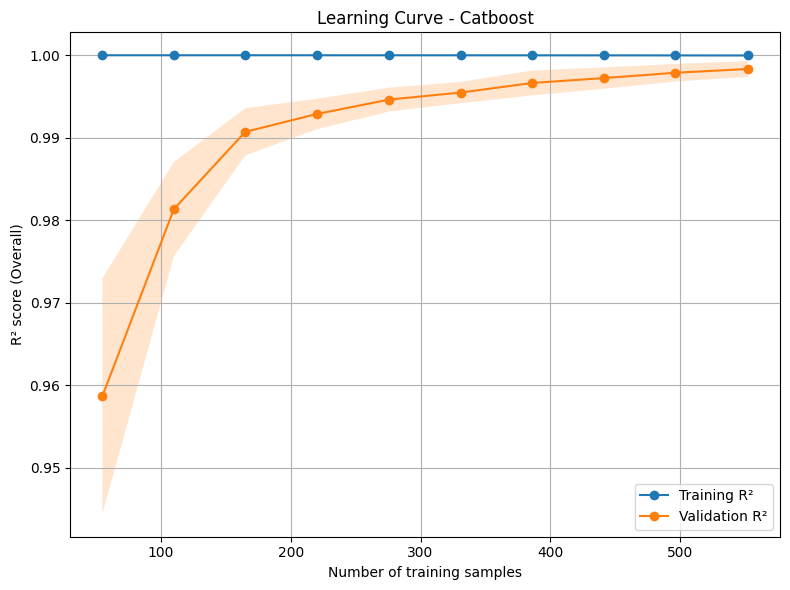

In [12]:
# Plot
plt.figure(figsize=(8, 6))

plt.plot(train_sizes, train_mean, marker="o", label="Training R²")
plt.fill_between(
    train_sizes,
    train_mean - train_std,
    train_mean + train_std,
    alpha=0.2
)

plt.plot(train_sizes, val_mean, marker="o", label="Validation R²")
plt.fill_between(
    train_sizes,
    val_mean - val_std,
    val_mean + val_std,
    alpha=0.2
)

plt.xlabel("Number of training samples")
plt.ylabel("R² score (Overall)")
plt.title("Learning Curve - Catboost")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'catboost_learning_curve.png'))
plt.show()